In [2]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [18]:
def conv3x3(in_planes, out_planes, stride = 1):
  return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)

def conv1x1(in_planes, out_planes, stride = 1):
  return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

In [6]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride = 1, downsample = None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace = True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = nn.BatchNorm2d(planes)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
# downsample 의 역할 = stride의 값이 1이 아닌 다를 수 일 경우에는 특징 벡터의 크기가 주어들게 된다.
    if self.downsample is not None:
      identity = self.downsample(x)
    
    out += identity
    out = self.relu(out)

    return out


In [16]:
class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride = 1, downsample = None):
    super(Bottleneck, self).__init__()
    self.conv1 = conv1x1(inplanes, planes) #conv1x1(64, 64)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = conv3x3(planes, planes, stride) #conv3x3(64, 64)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = conv1x1(planes, planes * self.expansion) #conv1x1(64, 256)
    self.relu = nn.ReLU(inplace = True)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)
    out += identity
    out = self.relu(out)

    return out


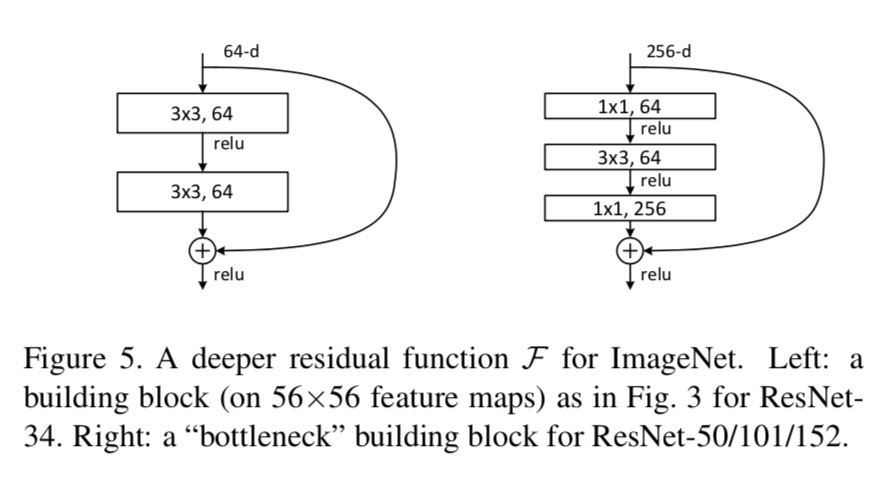

1. 위에 있는 사진에서 왼쪽에 있는 그림의 경우에는 BasicBlock의 형태, 오른쪽에 있는 그림의 경우에는 위와 아래의 kernel_size가 작은 값으로 일정한 Bottleneck의 형태이다.

2. ResNet18은 BasicBlock의 형태를 사용하고, ResNet50은 BottleNeck의 형태를 사용하게 된다.

3. 우리가 지정해 주어야 하는 값은 num_classe와 zero_init_residual값이고, 이는 class ResNet(nn.Module)을 이용해서 정의할 때에 **kwargs의 데이터로 입력을 받게 된다.


In [9]:
class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes = 1000, zero_init_residual = False):
    super(ResNet, self).__init__()

    self.inplanes = 64

    # inputs.shape = [3,3,64]

    self.conv1 = nn.Conv2d(3, 64, kernel_size = 2, stride = 2, padding = 3, bias = False)

    # outputs = self.conv1(inputs)
    # outputs.shape = [64x112x112]

    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace =  True)
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
    self.layer1 = self._make_layer(block, 64, layers[0], stride = 2)
    self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride = 2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      
      # 가중치 초기화를 gradient loss를 방지해 주기 위해서 수행해 준다.
      # 각각의 residual block가 독립적으로 작용하기 위해 각각의 residual block의 가중치를
      # 0으로 초기화 해 주는 과정이다.

      if zero_init_residual:
        for m in self.modules():
          if isinstance(m, Bottleneck):
            nn.init.constant_(m.bn3.weight, 0)
          elif isinstance(m, BasicBlock):
            nn.init.constant_(m.bn2.weight, 0)

  def _make_layer(self, block, planes, blocks, stride = 1):

    downsample = None

    if stride != 1 or self.inplanes != planes * block.expansion:

      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes*block.expansion, stride),
          nn.BatchNorm2d(planes*block.expansion)
      )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))

    self.inplanes = planes * block.expansion # self.inplanes = 256

    for _ in range(1, blocks):
      layers.append(block(self.inplanes, planes))
    
    return nn.Sequential(*layers)
# self.layer1 = [
#   Bottleneck(64, 64, 1, downsample)
#   Bottleneck(256, 64)
#   Bottleneck(256, 64)
#  ]
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [10]:

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


In [11]:
def resnet18(pretrained = False, **kwargs):
  model = ResNet(BasicBlock, [2,2,2,2], **kwargs)
  # self = ResNet, block = BasicBlock, layers = [2,2,2,2]
  # layer에는 kernel_size가 순서대로 저장되어 있는 list를 반환
  if pretrained:
    model.load_state_dict(model_zoo.load_ire(model_urls['resnet18']))
  return model

In [14]:
def resnet50(pretrained = False, **kwargs):
  # Bottleneck 구조를 따르며, layer의 개수가 4개이며, 각각의 layer마다 들어있는 residual block의 개수가 인수로 주어진다.
  # 아래와 같이 custom 하게 되면 resnet50을 만들 수 있다.
  model = ResNet(Bottleneck, [3,4,6,3], **kwargs)
  if pretrained: 
    # 이미 ImageNet데이터셋으로 학습이 된 모델을 전이 학습을 적용해서 사용하고 싶다면 
    # 그냥 pretrained = True인 상태로 사용하는 것도 좋다.
    model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
  return model

In [19]:
ResNet50 = resnet50()

In [20]:
ResNet50
# ResNet50의 구조는 아래와 같다.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

#### 위의 ResNet class를 이용해서 이제 Cifar10과 같은 이미지 데이터셋을 학습 시키는 것이 가능하다.

In [33]:
import torchvision.models.resnet as resnet

In [34]:
ResNet50 = ResNet(resnet.Bottleneck, [3,4,6,3], 10, True).to(device)
#1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) + 1(fc) = ResNet50
# 3 * (3+4+6+3) +2 * 1 = 50

In [22]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torchvision.datasets as dset

In [23]:
# 기본적인 device 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed(_all777) # cuda의 경우에는 할당되는 device의 개수가 여러개 일 수 있기 때문

```python
torchvision.transforms.Normalize(mean, std, inplace=False)
```
- Normalize a tensor image with mean and standard deviation. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels 
- Then this transform will normalize each channel of the input torch.*Tensor i.e.,   
    - output[channel] = (input[channel] - mean[channel]) / std[channel]

1. Parameters:	
  - mean (sequence) – Sequence of means for each channel.
  - std (sequence) – Sequence of standard deviations for each channel.
  - inplace (bool,optional) – Bool to make this operation in-place.

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

- trainset, testset, trainloader, testloader을 정의 하는 과정
- 데이터는 trochvision.datasets에 저장되어 있는 CIFAR10데이터를 이용한다.

In [25]:
trainset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = True, transform = transform, download = True)
trainloader = torch.utils.data.DataLoader(trainset, shuffle = True,batch_size = 512) 
testset = torchvision.datasets.CIFAR10(root = './CIFAR10', train=False, 
                                       download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False, num_workers = 0)

# python의 특징중 하나가 class에 .next()함수가 구현이 되어있다는 것이다.
# .next()함수와 iter은 함께 사용해야 함
# 다음 요소를 쉽게 불러 주는 기능을 한다.

dataiter = iter(trainloader)
images, labels = dataiter.next()

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [36]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save:
        torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

In [28]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ResNet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [ ]:
print(len(trainloader))
epochs = 150

for epoch in range(epochs):  

    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Pytorch로 직접 훈련을 시킬 때에 반드시 수행해 주어야 하는 과정
        # Pytorch의 optimzer의 경우에는 가중치를 계속해서 쌓아 올리는 특징이 존재한다.
        # 따라서 이를 zero_grad()를 이용해서 모두 0으로 초기화 해 주는 과정이 필요하다.
        
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = ResNet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(ResNet50, testloader, epoch, save=1)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')